In [1]:
import h5py
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
import numpy as np
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
from load_data import load_data

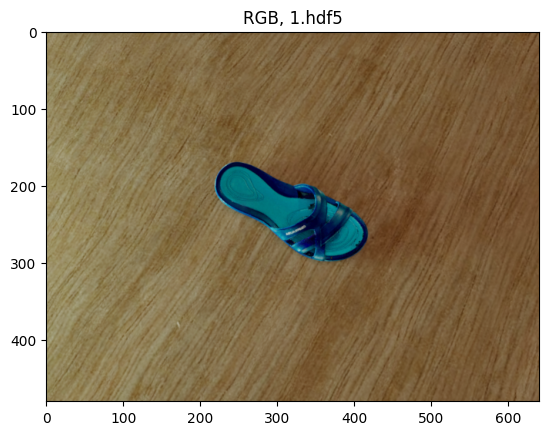

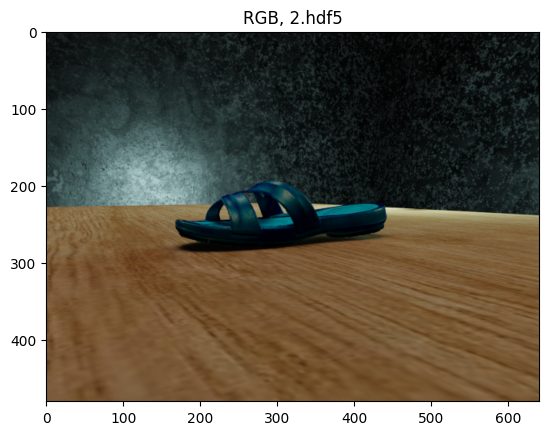

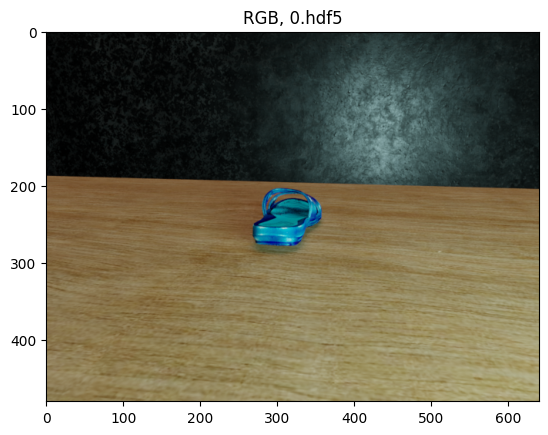

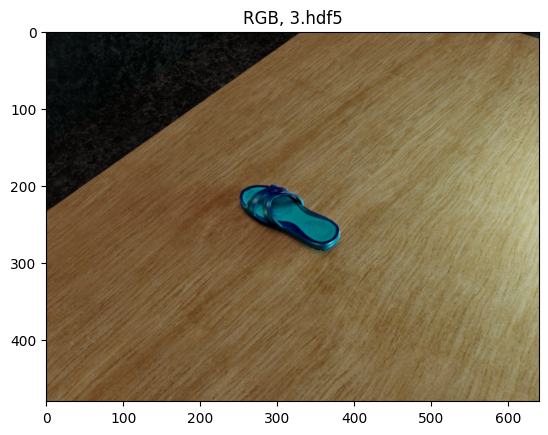

In [2]:
idx = 0
path = Path("../../output/", "dataset_rendered", "shoe-aqua_cyan_right")
mesh_path = Path("../../data", "housecat6d_meshes")
for file_name in os.listdir(path):
    if file_name.endswith('.hdf5'):
        file = h5py.File(path / file_name, 'r')

        rgb = file['colors']
        depth = file['depth']
        instance_attribute_maps = file['instance_attribute_maps']
        instance_segmaps = file['instance_segmaps']

        plt.figure()
        plt.imshow(rgb)
        plt.title(f'RGB, {file_name}')

In [3]:
rgb_images, object_masks, poses, scene_names = load_data(path.parent)

0.hdf5
1.hdf5
2.hdf5
3.hdf5
poses.json


In [5]:
import matplotlib.pyplot as plt
obj1 = "shoe-aqua_cyan_right"
obj1_idx = 3
img1 = rgb_images[obj1][obj1_idx]

In [6]:
object1_pose = np.array(poses[obj1][obj1])
cam1_pose = np.array(poses[obj1]['cam_'+str(obj1_idx)])
cam_to_object1 = cam1_pose @ np.linalg.inv(object1_pose)
cam_to_object2 = cam1_pose @ object1_pose
cam_to_object3 = np.linalg.inv(cam1_pose) @ object1_pose
cam_to_object4 = np.linalg.inv(cam1_pose) @ np.linalg.inv(object1_pose)
cam_to_object5 = object1_pose @ np.linalg.inv(cam1_pose)
cam_to_object6 = object1_pose @ cam1_pose
cam_to_object7 = np.linalg.inv(object1_pose) @ cam1_pose
cam_to_object8 = np.linalg.inv(object1_pose) @ np.linalg.inv(cam1_pose)

In [7]:
print(object1_pose)
print(cam1_pose)
print(cam_to_object1)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  1.08777605e-01]
 [ 0.00000000e+00  7.54979013e-08 -1.00000000e+00  1.25925615e-01]
 [ 0.00000000e+00  1.00000000e+00  7.54979013e-08  9.31285620e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.05685580e-01  4.60691035e-01 -3.72336715e-01 -2.23589565e-01]
 [-5.92343509e-01 -6.26616359e-01  5.06439686e-01  5.78000026e-01]
 [-5.61246409e-08  6.28582358e-01  7.77743042e-01  1.62553952e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-8.05685580e-01  3.72336750e-01  4.60691007e-01 -6.11870662e-01]
 [-5.92343509e-01 -5.06439733e-01 -6.26616321e-01  1.28976624e+00]
 [-5.61246409e-08 -7.77742994e-01  6.28582417e-01  1.13808752e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[[ 0.10525   -0.0174475  0.027434 ]
 [ 0.10569   -0.0160225  0.026945 ]
 [ 0.104849  -0.0157235  0.027775 ]
 ...
 [ 0.114577  -0.0209245  0.008744 ]
 [ 0.11488   -0.0205305  0.009228 ]
 [ 0.114577  -0.0209245  0.008744 ]]
0.123990997672081
[[-0.06854808 -0.05471115  0.95930381]
 [-0.06919224 -0.05550317  0.95811171]
 [-0.06802302 -0.05582377  0.95798637]
 ...
 [-0.08713361 -0.04511098  0.95601545]
 [-0.08709104 -0.04580151  0.95606696]
 [-0.08713361 -0.04511098  0.95601545]]
0.9634092467134397
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x5639e1601af0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


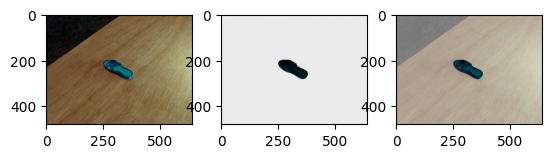

In [8]:
import open3d as o3d

model = o3d.io.read_triangle_model(str(mesh_path / 'shoe' / f"{obj1}.obj"))
mesh = model.meshes[0].mesh
mesh_name = model.meshes[0].mesh_name
mat = model.materials[0]

transform = cam_to_object3

print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))
rot_x_180 = np.eye(4)
rot_x_180[1, 1] = -1
rot_x_180[2, 2] = -1
mesh.transform((rot_x_180 @ transform))
print(np.asarray(mesh.vertices))
print(np.max(np.asarray(mesh.vertices)))

width = 640  
height = 480  
intrinsics = np.array([[538.391033533567, 0.0, 315.3074696331638], 
                       [0.0, 538.085452058436, 233.0483557773859], 
                       [0.0, 0.0, 1.0]], dtype=np.float64)
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]

intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

if 'renderer' in globals():
    del renderer
renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)
renderer.scene.add_geometry(mesh_name, mesh, mat)
renderer.setup_camera(intrinsics, np.eye(4, dtype=np.float64))
img = renderer.render_to_image()
img_np = np.asarray(img)
img_labeled = img1.copy()
alpha = 0.5
img_labeled = (img_labeled * alpha + img_np * (1 - alpha)).astype(np.uint8)
# print both
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img_np)
plt.subplot(1, 3, 3)
plt.imshow(img_labeled)
plt.show()